In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [3]:
def draw_sample_image(X,Y):
    labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    X, Y = shuffle(X, Y)
    for i in xrange(20):
        plt.subplot(4,5,i)
        img = X[i].reshape(32,32,3)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.title(labels[Y[i]])
    plt.show()

## Display some sample images 

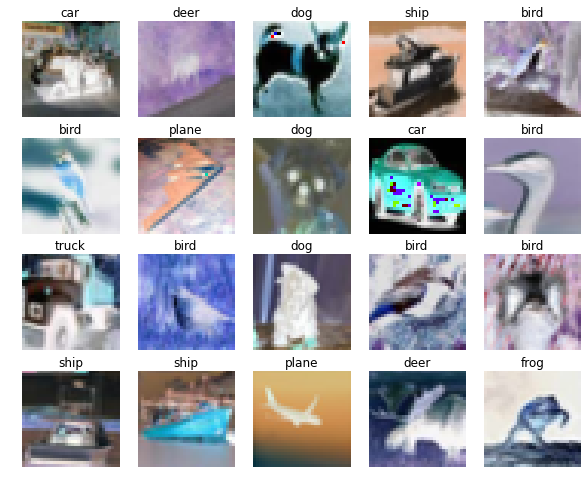

In [4]:
draw_sample_image(X_train,y_train)

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
# num_training = 49000
# num_validation = 1000
# num_test = 1000
# num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
# mask = range(num_training, num_training + num_validation)
# X_val = X_train[mask]
# y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
# mask = range(num_training)
# X_train = X_train[mask]
# y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
# mask = np.random.choice(num_training, num_dev, replace=False)
# X_dev = X_train[mask]
# y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
# mask = range(num_test)
# X_test = X_test[mask]
# y_test = y_test[mask]

# print 'Train data shape: ', X_train.shape
# print 'Train labels shape: ', y_train.shape
# print 'Validation data shape: ', X_val.shape
# print 'Validation labels shape: ', y_val.shape
# print 'Test data shape: ', X_test.shape
# print 'Test labels shape: ', y_test.shape

In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1)) /255
# X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
# X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
# print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
# print 'dev data shape: ', X_dev.shape

Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)


In [7]:
#Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
# mean_image = np.mean(X_train, axis=0)
# print mean_image[:10] # print a few of the elements
# plt.figure(figsize=(4,4))
# plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
# plt.show()

In [8]:
# second: subtract the mean image from train and test data
# X_train -= mean_image
# # X_val -= mean_image
# X_test -= mean_image
# # X_dev -= mean_image

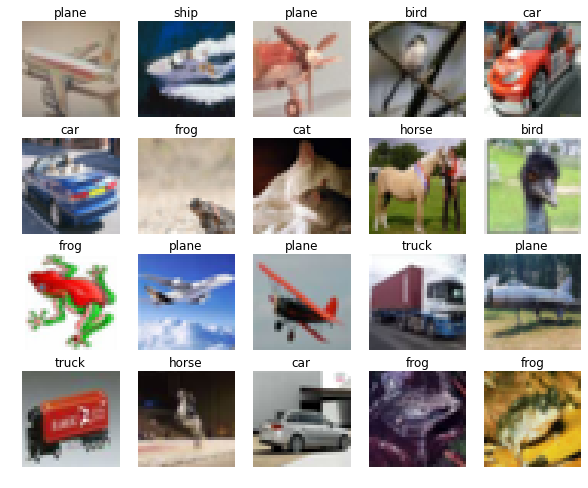

In [9]:
draw_sample_image(X_train,y_train)

In [10]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)
def cost(T, Y):
    return -(T*np.log(Y)).sum()
def cost2(T, Y):
    # same as cost(), just uses the targets to index Y
    # instead of multiplying by a large indicator matrix with mostly 0s
    N = len(T)
    return -np.log(Y[np.arange(N), T]).mean()
def y2indicator(Y):
    N = len(Y)
    K = len(set(Y))
    y_ind = np.zeros((N,K))
    for i in xrange(N):
        y_ind[i,Y[i]] = 1
    return y_ind
def error_rate(targets,predictions):
    return np.mean(targets != predictions)
class LogisticModel(object):
    def __init__(self):
        pass
    def train(self, X, Y, learning_rate=10e-7, reg=1e-8, epochs=1000, show_fig=True):
        X, Y = shuffle(X, Y)
        X_valid, Y_valid = X[-1000:],Y[-1000:]
        T_valid = y2indicator(Y_valid)
        X, Y = X[:-1000],Y[:-1000]
        N,D = X.shape
        K = len(set(Y))
        T = y2indicator(Y)
        self.W = np.random.randn(D,K) / np.sqrt(D + K)
        self.b = np.zeros(K)
        costs = []
        best_validation_error = 1
        for epoch in xrange(epochs):
            P_Y = self.forward(X)
            #update the weight 
            self.W -= learning_rate*(X.T.dot(P_Y - T) + reg*self.W)
            self.b -= learning_rate*((P_Y - T).sum(axis=0) + reg*self.b)
            if epoch % 100 == 0:
                P_Y_valid = self.forward(X_valid)
                c = cost(T_valid,P_Y_valid)
                costs.append(c)
                e = error_rate(Y_valid,np.argmax(P_Y_valid,axis=1))
                print "epoch:", epoch, "cost:", c, "error:", e
                if e < best_validation_error:
                    best_validation_error = e
        print "best_validation_error:", best_validation_error
        if show_fig:
            plt.plot(costs)
            plt.show()
    def forward(self,X):
        return softmax(X.dot(self.W) + self.b)
    def predict(self,X):
        P_Y = self.forward(X)
        return np.argmax(P_Y,axis=1)
    def score(self,X,Y):
        prediction = self.predict(X)
        return 1 - error_rate(prediction,Y)

epoch: 0 cost: 2900.73533001 error: 0.907
epoch: 100 cost: 2779.722813 error: 0.742
epoch: 200 cost: 2722.78995668 error: 0.713
epoch: 300 cost: 2490.1574888 error: 0.757
epoch: 400 cost: 2697.83015632 error: 0.69
epoch: 500 cost: 2486.60154852 error: 0.702
epoch: 600 cost: 2388.54175698 error: 0.673
epoch: 700 cost: 2497.70031652 error: 0.655
epoch: 800 cost: 2460.44836723 error: 0.706
epoch: 900 cost: 2363.48532804 error: 0.695
best_validation_error: 0.655


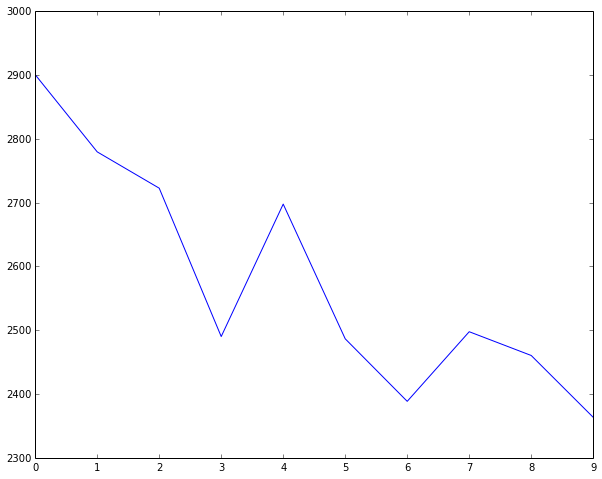

In [11]:
logis = LogisticModel()
logis.train(X_train,y_train)

############### testing model with l:  1e-07 r:  50000.0 #######
epoch: 0 cost: 2727.06366272 error: 0.88
epoch: 100 cost: 2811.43921745 error: 0.73
epoch: 200 cost: 2783.96032441 error: 0.76
epoch: 300 cost: 2678.67579895 error: 0.763
epoch: 400 cost: 2869.74551996 error: 0.707
epoch: 500 cost: 2395.33784715 error: 0.706
epoch: 600 cost: 2798.38426518 error: 0.731
epoch: 700 cost: 2493.54167514 error: 0.692
epoch: 800 cost: 2626.61865876 error: 0.707
epoch: 900 cost: 2331.34716186 error: 0.702
best_validation_error: 0.692


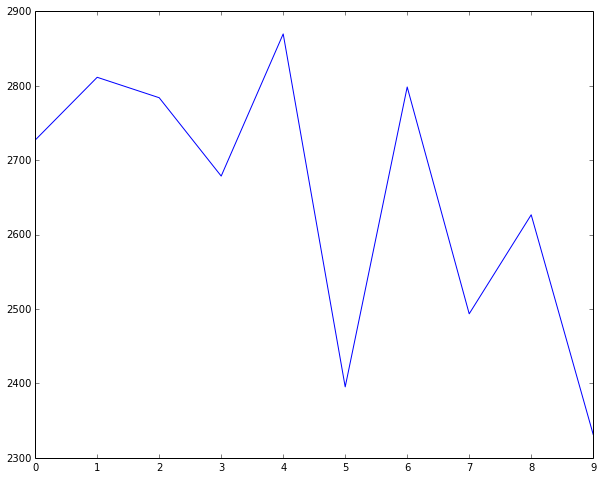

/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


############### testing model with l:  1e-07 r:  1000000.0 #######
epoch: 0 cost: 2682.10947297 error: 0.861
epoch: 100 cost: 2780.75393445 error: 0.697
epoch: 200 cost: 3056.41220681 error: 0.746
epoch: 300 cost: 2298.8684305 error: 0.714
epoch: 400 cost: 2609.4237191 error: 0.768
epoch: 500 cost: 2587.79520376 error: 0.692
epoch: 600 cost: 2281.77982268 error: 0.698
epoch: 700 cost: 2535.4750202 error: 0.702
epoch: 800 cost: 2334.09447895 error: 0.689
epoch: 900 cost: 2674.44103821 error: 0.665
best_validation_error: 0.665


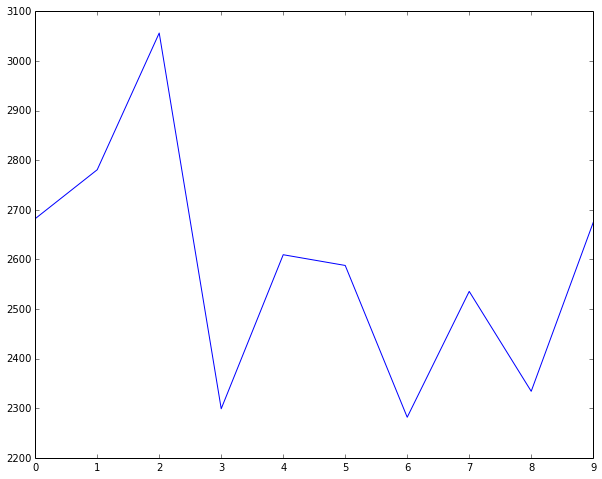

############### testing model with l:  5e-05 r:  50000.0 #######
epoch: 0 cost: 2624.93177911 error: 0.916
epoch: 100 cost: 3140.18160082 error: 0.746
epoch: 200 cost: 2597.95906461 error: 0.772
epoch: 300 cost: 2616.9650974 error: 0.788
epoch: 400 cost: 3131.29249222 error: 0.731
epoch: 500 cost: 2327.58514809 error: 0.696
epoch: 600 cost: 2437.90186039 error: 0.733
epoch: 700 cost: 2507.04807266 error: 0.712
epoch: 800 cost: 2558.26703371 error: 0.695
epoch: 900 cost: 2750.67515873 error: 0.711
best_validation_error: 0.695


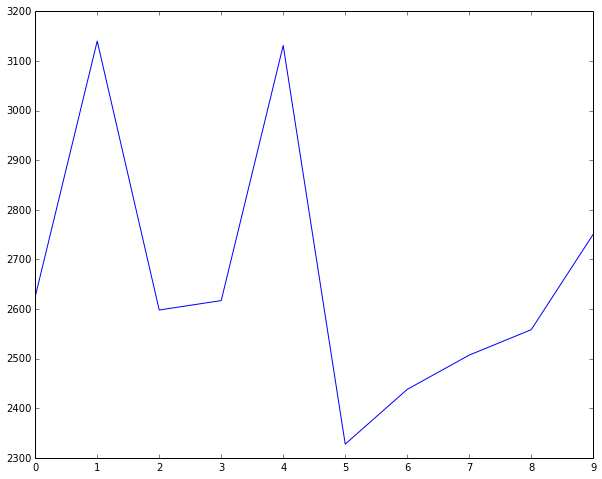

############### testing model with l:  5e-05 r:  1000000.0 #######
epoch: 0 cost: 2635.84990272 error: 0.87
epoch: 100 cost: 3089.88050559 error: 0.76
epoch: 200 cost: 2667.30119947 error: 0.748
epoch: 300 cost: 2802.89895725 error: 0.713
epoch: 400 cost: 2474.09957773 error: 0.728
epoch: 500 cost: 2682.5007238 error: 0.68
epoch: 600 cost: 2045.63951705 error: 0.697
epoch: 700 cost: 2379.64598546 error: 0.711
epoch: 800 cost: 3007.70067417 error: 0.683
epoch: 900 cost: 2559.07162267 error: 0.696
best_validation_error: 0.68


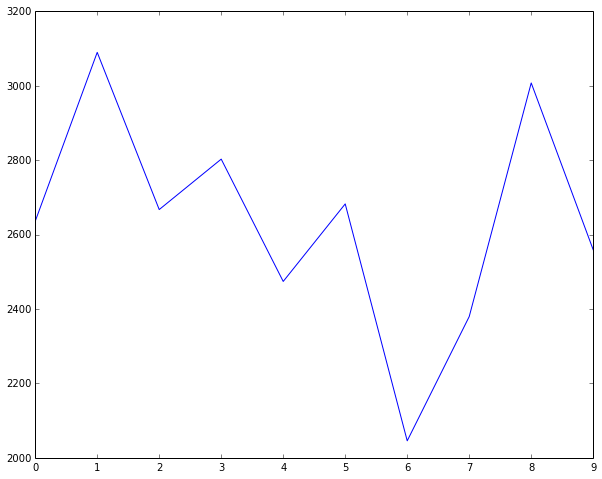

lr 1.000000e-07 reg 5.000000e+04 train score: 0.280600 val score: 0.281000
lr 1.000000e-07 reg 1.000000e+06 train score: 0.300100 val score: 0.286800
lr 5.000000e-05 reg 5.000000e+04 train score: 0.336780 val score: 0.313000
lr 5.000000e-05 reg 1.000000e+06 train score: 0.317440 val score: 0.257800
best validation accuracy achieved during cross-validation: 0.313000


In [12]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [5e4, 1e6]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_logis = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for l in learning_rates:
    for r in regularization_strengths:
        print "############### testing model with l: ", l, "r: ", r, "#######"
        logis = LogisticModel()
        logis.train(X_train,y_train)
        training_score = logis.score(X_train,y_train)
        valid_score = logis.score(X_test,y_test)
        results[(l,r)] = (training_score, valid_score)
        if valid_score > best_val:
            best_val = valid_score
            best_svm = logis
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    training_score, valid_score = results[(lr, reg)]
    print 'lr %e reg %e train score: %f val score: %f' % (
                lr, reg, training_score, valid_score)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

In [13]:
best_val

0.31299999999999994